## Этап 1. Сбор и подготовка данных

In [1]:
from datetime import datetime
import json
import random

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.baseline_comparison import DistilGPT2Baseline
from src.model_evaluation import compare_models, generate_examples
from src.configs import CONFIG, DATA_PATH, PROJECT_PATH, TOKENIZER
from src.next_token_dataset import NextTokenDataset, collate_fn
from src.lstm_model import LSTMModel
from src.lstm_train import train_model
from src.data_utils import load_tweets, process_tweets_dataset, split_data

/Users/pavelstepanov/dl_projects/text-autocomplete/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__

(device(type='cpu'), '2.7.1')

In [3]:
random.seed(42)
torch.manual_seed(42)

### Загружаем и обрабатываем твиты

In [4]:
processed_texts = process_tweets_dataset(tokenizer=TOKENIZER)

In [5]:
print(processed_texts[0])

['<', 'user', '>', '<', 'ur', '##l', '>', 'aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer', '.', 'you', 'should', '##a', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


### Разбиваем датасет на трейн, валидацию и тест

In [6]:
train_texts, val_texts, test_texts = split_data(processed_texts)

In [7]:
train_dataset = NextTokenDataset(train_texts, TOKENIZER)
val_dataset   = NextTokenDataset(val_texts, TOKENIZER)
test_dataset  = NextTokenDataset(test_texts, TOKENIZER)

In [8]:
pad_token_id = TOKENIZER.pad_token_id or 0
batch_size = CONFIG['training']['batch_size']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))
    
test_loader  = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

## Этап 2. Объявление модели

In [9]:
model = LSTMModel(
    vocab_size = TOKENIZER.vocab_size,
    embed_dim=CONFIG['model']['embed_dim'],
    hidden_dim=CONFIG['model']['hidden_dim'],
    num_layers=CONFIG['model']['num_layers'],
    pad_token_id=pad_token_id
)

## Этап 3. Тренировка модели

In [10]:
trained_model, best_path = train_model(
    model, train_loader, val_loader, TOKENIZER, device,
    epochs=CONFIG['training']['epochs'],
    lr=CONFIG['training']['lr'],
    weight_decay=CONFIG['training']['weight_decay'],
    pad_token_id=pad_token_id
)

Epoch 4/10:  16%|█▌        | 20/126 [00:08<00:43,  2.46it/s]


KeyboardInterrupt: 

## Этап 4. Использование предобученного трансформера

Загрузка baseline модели

In [11]:
baseline = DistilGPT2Baseline()

Загрузка предобученной модели distilgpt2...


Device set to use cpu


Модель загружена успешно!


Создаем валидационную выборку из исходных текстов

In [12]:
train_original, val_original, test_original = split_data(
    load_tweets(),
    save_data=False
)

In [13]:
evaluate_scores(baseline, val_original)

NameError: name 'evaluate_scores' is not defined

## Этап 5. Формулирование выводов

Сравниваем производительность двух моделей на валидационной выборке

In [ ]:
results = compare_models(model, baseline, val_loader, val_original, device)


=== Сравнение LSTM с baseline моделью ===
Оценка LSTM модели...


INFO:absl:Using default tokenizer.


Оценка baseline модели...
Оценка distilgpt2 на 2000 примерах...


100%|██████████| 2000/2000 [02:13<00:00, 14.98it/s]
INFO:absl:Using default tokenizer.


Обработано 1974 примеров

Сравнение результатов:
Модель          ROUGE-1    ROUGE-2    ROUGE-L   
--------------------------------------------------
LSTM            0.0334     0.0028     0.0327
Baseline        0.0658     0.0084     0.0651

Baseline показывает лучшие результаты (ROUGE-L: 0.0651 vs 0.0327)


Извлекаем результаты для графиков

In [ ]:
lstm_rouge1 = results['lstm_rouge1']
lstm_rouge2 = results['lstm_rouge2']
lstm_rouge_l = results['lstm_rouge_l']
final_rouge1 = results['baseline_rouge1']
final_rouge2 = results['baseline_rouge2']
final_rouge_l = results['baseline_rouge_l']

График сравнения ROUGE метрик

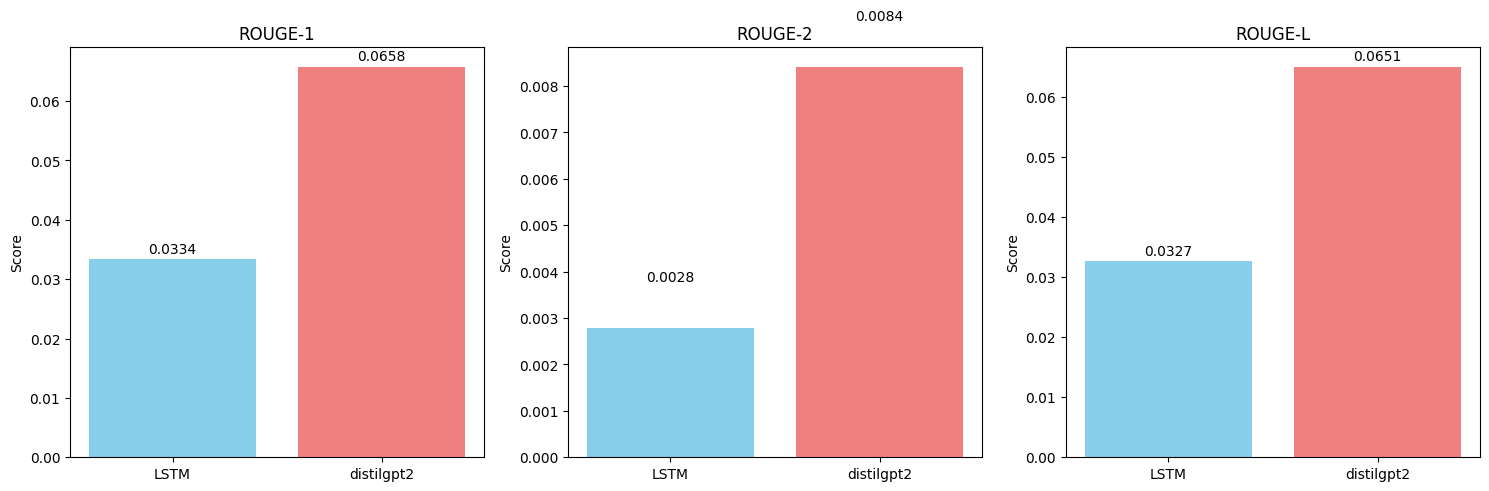

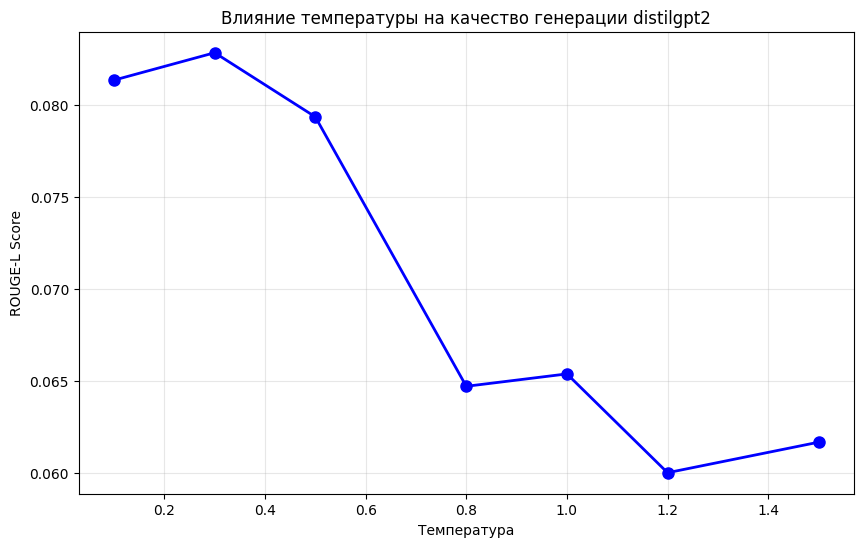

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['LSTM', 'distilgpt2']
rouge1_scores = [lstm_rouge1, final_rouge1]
rouge2_scores = [lstm_rouge2, final_rouge2]
rougeL_scores = [lstm_rouge_l, final_rouge_l]

axes[0].bar(models, rouge1_scores, color=['skyblue', 'lightcoral'])
axes[0].set_title('ROUGE-1')
axes[0].set_ylabel('Score')
for i, v in enumerate(rouge1_scores):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[1].bar(models, rouge2_scores, color=['skyblue', 'lightcoral'])
axes[1].set_title('ROUGE-2')
axes[1].set_ylabel('Score')
for i, v in enumerate(rouge2_scores):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[2].bar(models, rougeL_scores, color=['skyblue', 'lightcoral'])
axes[2].set_title('ROUGE-L')
axes[2].set_ylabel('Score')
for i, v in enumerate(rougeL_scores):
    axes[2].text(i, v + 0.001, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

Выбираем несколько примеров из валидационной выборки

In [27]:
sample_indices = [0, 10, 50, 100, 200]
sample_texts = [val_original[i] for i in sample_indices if i < len(val_original)]

Генерация примеров

In [ ]:
examples = generate_examples(model, baseline, TOKENIZER, device, sample_texts)


=== Примеры генерации ===

--- Пример 1 ---
Исходный текст: @mgatton nice hair cut!  dude why were your students leaving in the middle of class, 1st period?
...
Контекст: < user > nice hair cut! dude why were your students leaving in the middle
Ожидаемое продолжение: of class, 1st period?
LSTM продолжение: ?!? xxx? i ' m sad.
Baseline продолжение: of the night?

--- Пример 2 ---
Исходный текст: Just packed my stethoscope 
...
Контекст: just packed my steth
Ожидаемое продолжение: ##oscope
LSTM продолжение: : ' my face!!!
Baseline продолжение: oscope and I was able to get

--- Пример 3 ---
Исходный текст: I couldn't go to the Revlon Run Walk today because my formerly broken ankle is throbbing.  
...
Контекст: i couldn ' t go to the revlon run walk today because my formerly
Ожидаемое продолжение: broken ankle is throbbing.
LSTM продолжение: was still a huge......
Baseline продолжение: -in-law, a former employee, was

--- Пример 4 ---
Исходный текст: too much ice cream! 
...
Контекст: too